In [1]:
import matplotlib.pyplot as plt
import polars as pl
import os

from datetime import datetime

In [2]:
# Get the absolute path of the current working directory
cwd = os.path.abspath(os.getcwd())

# Get the absolute path of the parent directory of the working directory
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))

# Navigate to the target directory (assuming it is two levels above the working directory)
target_dir = os.path.abspath(os.path.join(parent_dir, os.pardir, 'data'))

In [3]:
# hard coded list of USDC addresses taken from the various _scan.com websites
usdc_list = [
    '0x2791Bca1f2de4661ED88A30C99A7a9449Aa84174', # polygon
    '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', # ethereum
    '0xFF970A61A04b1cA14834A43f5dE4533eBDDB5CC8', # arbitrum
    '0x7F5c764cBc14f9669B88837ca1490cCa17c31607', # optimism
]

# for every element in usdc_list, convert all uppercase to lowercase
usdc_list = [address.lower() for address in usdc_list]

In [4]:
# load swaps_df
swaps_df = pl.read_parquet(f'{target_dir}/swaps_df.parquet')

### USDC Supply Flow into LPs

In [5]:
# filter swaps_df for values in usdc_list
usdc_inflow = swaps_df.filter(pl.col('swaps_tokenIn_id').is_in(usdc_list))
usdc_outflow = swaps_df.filter(pl.col('swaps_tokenOut_id').is_in(usdc_list))

In [6]:
print(f'usdc_inflow size: {usdc_inflow.shape[0]}')
print(f'usdc_outflow size: {usdc_outflow.shape[0]}')

usdc_inflow size: 495582
usdc_outflow size: 453045


In [7]:
# USDC decimal conversion
usdc_inflow = usdc_inflow.with_columns([
    (pl.col("swaps_amountIn") / 10**6).alias('swaps_amountIn')
])

usdc_outflow = usdc_outflow.with_columns([
    (pl.col("swaps_amountOut") / 10**6).alias('swaps_amountOut')
])

In [30]:
# round timestamp datetime to nearest date
usdc_inflow = usdc_inflow.with_columns([
    pl.col('swaps_timestamp').cast(pl.Date).alias('swaps_timestamp')
])

usdc_outflow = usdc_outflow.with_columns([
    pl.col('swaps_timestamp').cast(pl.Date).alias('swaps_timestamp')
])

In [35]:
# group by daily and endpoint and sum 
usdc_inflow = usdc_inflow.groupby(['swaps_timestamp', 'endpoint']).agg(pl.sum('swaps_amountIn').alias('swaps_amountIn'))
usdc_outflow = usdc_outflow.groupby(['swaps_timestamp', 'endpoint']).agg(pl.sum('swaps_amountOut').alias('swaps_amountOut'))

# sort by date
usdc_inflow = usdc_inflow.sort('swaps_timestamp')
usdc_outflow = usdc_outflow.sort('swaps_timestamp')

In [37]:
# define date time object for 2021-03-09
march_9 = datetime(2023, 3, 9)
march_11 = datetime(2023, 3, 11)
march_13 = datetime(2023, 3, 13)

In [42]:
# join usdc_inflow_grouped and usdc_outflow_grouped
usdc_inflow_outflow = usdc_inflow.join(usdc_outflow, on=['endpoint', 'swaps_timestamp'], how='inner')

In [123]:
# subtract amountIn from amountOut to get surplus. Surplus is the amount of extra USDC going into LPs
usdc_inflow_outflow = usdc_inflow_outflow.with_columns([
    (pl.col('swaps_amountIn') - pl.col('swaps_amountOut')).alias('surplus')
])

### plot daily changes

In [124]:
# group usdc_inflow_outflow by day
usdc_inflow_outflow_daily = usdc_inflow_outflow.groupby(['swaps_timestamp', 'endpoint']).agg(pl.sum('surplus').alias('surplus'))

In [125]:
# sort by date
pandas_df = usdc_inflow_outflow_daily.sort('swaps_timestamp').to_pandas()

In [127]:
# pivot the dataframe into the correct format
dfp = pandas_df.pivot(index='swaps_timestamp', columns='endpoint', values=['surplus'])

In [142]:
dfp.index

DatetimeIndex(['2023-03-09', '2023-03-10', '2023-03-11', '2023-03-12',
               '2023-03-13'],
              dtype='datetime64[ns]', name='swaps_timestamp', freq=None)

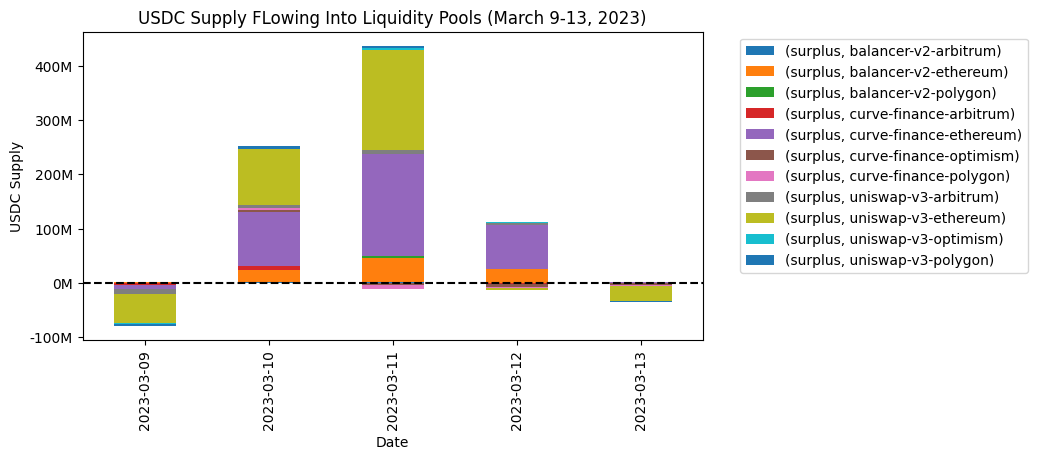

In [151]:
# plot the pivoted dataframe
dfp.plot.bar(y=['surplus'], stacked=True, figsize=(8, 4), ylabel='USDC Supply', xlabel='Date', title='USDC Supply FLowing Into Liquidity Pools (March 9-13, 2023)')
# draw horizontal line at 0
plt.axhline(y=0, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# convert y axis to millions
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000000)) + 'M'))
plt.show()